C:\Users\mmbar\AppData\Local\Temp\ipykernel_20400\3582365043.py:11: DtypeWarning: Columns (7,8,9,10,11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['TRANS DATE'], na_values=missing_values)


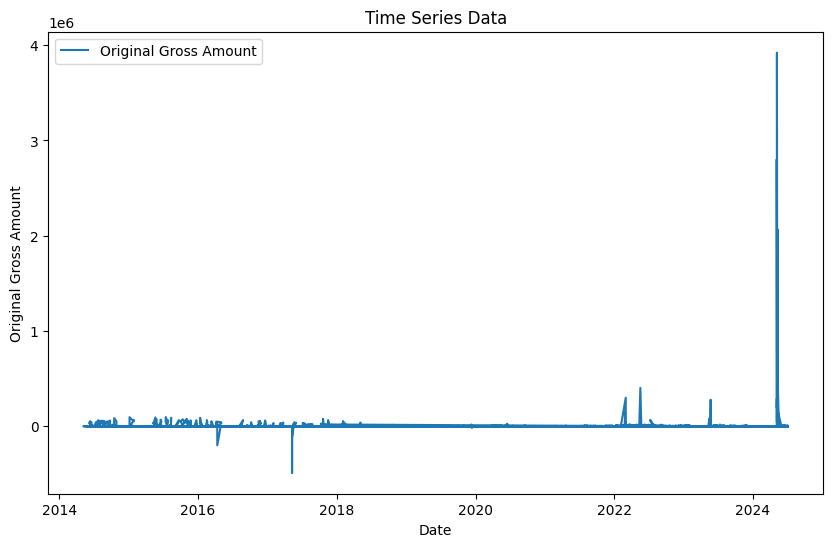

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'Data/data_clean.csv'

# Define values to treat as missing
missing_values = ["123"]

df = pd.read_csv(file_path, parse_dates=['TRANS DATE'], na_values=missing_values)

# Set the 'TRANS DATE' column as the index
df.set_index('TRANS DATE', inplace=True)

# Clean up the dataset by replacing invalid 'ORIGINAL GROSS AMT' entries with NaN
df['ORIGINAL GROSS AMT'] = pd.to_numeric(df['ORIGINAL GROSS AMT'], errors='coerce')

# Drop rows where 'ORIGINAL GROSS AMT' is NaN if these rows are not useful for analysis
df.dropna(subset=['ORIGINAL GROSS AMT'], inplace=True)


# Plot the time series to visualize the 'ORIGINAL GROSS AMT'
plt.figure(figsize=(10, 6))
plt.plot(df['ORIGINAL GROSS AMT'], label='Original Gross Amount')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Original Gross Amount')
plt.legend()
plt.show()


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima
from prophet import Prophet

# Load the CSV file
file_path = 'Data/data_clean_treated_normalized.csv'

# Define values to treat as missing
missing_values = ["123"]

df = pd.read_csv(file_path, parse_dates=['TRANS DATE'], na_values=missing_values)

# Set the 'TRANS DATE' column as the index
df.set_index('TRANS DATE', inplace=True)

# Clean up the dataset by replacing invalid 'ORIGINAL GROSS AMT' entries with NaN
df['ORIGINAL GROSS AMT'] = pd.to_numeric(df['ORIGINAL GROSS AMT'], errors='coerce')

# Drop rows where 'ORIGINAL GROSS AMT' is NaN if these rows are not useful for analysis
df.dropna(subset=['ORIGINAL GROSS AMT'], inplace=True)


# Ensure the data is sorted by date
df = df.sort_index()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['ORIGINAL GROSS AMT'], label='Original Gross Amount')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Original Gross Amount')
plt.legend()
plt.show()

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# ARIMA Model
def arima_forecast(train, test):
    model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    model_fit = model.fit(train)
    forecast = model_fit.predict(n_periods=len(test))
    return forecast

# SARIMA Model
def sarima_forecast(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Prophet Model
def prophet_forecast(train, test):
    train_df = train.reset_index().rename(columns={'TRANS DATE': 'ds', 'ORIGINAL GROSS AMT': 'y'})
    model = Prophet()
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(test), freq='D')
    forecast = model.predict(future)
    return forecast['yhat'].iloc[-len(test):].values

# Evaluate Models
def evaluate_model(forecast, test, model_name):
    rmse = sqrt(mean_squared_error(test, forecast))
    print(f'{model_name} RMSE: {rmse}')
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['ORIGINAL GROSS AMT'], label='Train')
    plt.plot(test.index, test['ORIGINAL GROSS AMT'], label='Test')
    plt.plot(test.index, forecast, label=f'{model_name} Forecast')
    plt.title(f'{model_name} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Original Gross Amount')
    plt.legend()
    plt.show()

# ARIMA Forecast
arima_forecast_values = arima_forecast(train['ORIGINAL GROSS AMT'], test['ORIGINAL GROSS AMT'])
evaluate_model(arima_forecast_values, test['ORIGINAL GROSS AMT'], 'ARIMA')

# SARIMA Forecast
sarima_forecast_values = sarima_forecast(train['ORIGINAL GROSS AMT'], test['ORIGINAL GROSS AMT'])
evaluate_model(sarima_forecast_values, test['ORIGINAL GROSS AMT'], 'SARIMA')

# Prophet Forecast
prophet_forecast_values = prophet_forecast(train['ORIGINAL GROSS AMT'], test['ORIGINAL GROSS AMT'])
evaluate_model(prophet_forecast_values, test['ORIGINAL GROSS AMT'], 'Prophet')


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject